In [1]:
import numpy as np
import pandas as pd

from shapely import Polygon, LineString, Point
from shapely.ops import unary_union
from shapely import wkt

import utm
import ast

In [2]:
def from_latlon(latitude, longitude, geozone_num, geozone_let):
    """
    convert lat, lon to (x, y) coordinates (in meters)
    :param latitude:  list or np.array (shape: (n,))
    :param longitude: list or np.array (shape: (n,))
    :param geozone_num: geozone integer
    :param geozone_let: geozone letter
    :return: np.array of (x, y) coordinates (shape: (n, 2))
    """
    xy = np.array([
        utm.from_latlon(
            latitude=lat, 
            longitude=lon, 
            force_zone_number=geozone_num,
            force_zone_letter=geozone_let
        )[:2] for lat, lon in zip(latitude, longitude)
    ])
    return xy



def get_subfields_xy(field_bounds: list, geozone_num, geozone_let):
    """
    convert GPS bounds of field into (x, y) coordinates (in meters)
    :param field_bounds: list with GPS bounds of subfields
    :return: list of (x, y) bounds of the subfields
    """
    subfields = [np.array(subfield).T for subfield in field_bounds]
    bounds_xy = [from_latlon(field[1], field[0], geozone_num, geozone_let) for field in subfields]
    return bounds_xy



def get_bounds_from_string(field_bounds_str : str):
    """
    convert string representation of the bounds into list
    :param field_bounds_str: string representation of the bounds
    :return: list of bounds of the subfields
    """
    if field_bounds_str[:4] == '[[[[':
        field_bounds_str = field_bounds_str.replace('[[[', '[[').replace(']]]', ']]')
    field_bounds = ast.literal_eval(field_bounds_str) 
    return field_bounds



def get_geozone(latitude, longitude):
    """
    :param latitude: 
    :param longitude: 
    :return: UTM geozone number and letter
    """
    geozone_num, geozone_let = utm.from_latlon(latitude, longitude)[2:]
    return geozone_num, geozone_let



def get_polygon_from_str_bounds(field_bounds_str, geozone_num, geozone_let):
    """
    get field polygon from string representation of its bounds
    :param field_bounds_str: string representation of the bounds of the field
    :param geozone_num: utm geozone number
    :param geozone_let: utm geozone letter
    :return: shapely field polygon
    """
    # get GPS field bounds from string representation
    field_bounds = get_bounds_from_string(field_bounds_str)
    # convert GPS field bounds to XY and create field_polygon
    subfields_xy = get_subfields_xy(field_bounds, geozone_num, geozone_let)
    field_polygon = unary_union([
        Polygon(subfield).buffer(0) if len(subfield) > 1 else None for subfield in subfields_xy
    ])
    return field_polygon



def denoise_track(track_xy, simplification_m):
    """
    get denoised track 
    :param track_xy: XY-coordinates of the original track
    :param simplification_m: simplification tolerance
    :return: denoised track 
    """
    # create track LineString object
    track = LineString(track_xy)
    # simplify the track
    simplified_track = track.simplify(simplification_m)
    # project each point of the original track onto the simplified track
    projected_points = [
        simplified_track.interpolate(
            simplified_track.project(
                Point(x, y)
            )
        )
        for x, y in track_xy
    ]
    return projected_points

# Main function : area and distance calculator

In [3]:
def get_area_and_distance(
    tool_width : float,
    gps_m_deviation : float,
    
    time : list,
    track_lat : list,
    track_lon : list,
    
    field_bounds_str : str,
    
    encoded_field_polygon : str = None,
    encoded_calculated_track : str = None,
    
    gps_geozone_num : int = None,
    gps_geozone_let : str = None,
    
    last_point_xy : list = None,
    
    last_path_distance : float = 0,
    track_polygon_simplification_m = 0.3
):
    """
    calculates cumulative path distances and processed field area
    :param tool_width: float : tool-width
    :param gps_m_deviation: float : GPS deviation in meters
    :param time: list timestamps
    :param track_lat: list of track latitudes
    :param track_lon: list of track longitudes
    :param field_bounds_str: string with raw GPS field bounds
    :param encoded_field_polygon:  encoded version of the polygon in XY-system
    :param encoded_calculated_track: encoded version of the polygon in XY-system
    :param gps_geozone_num: GPS geozone number (UTM)
    :param gps_geozone_let: GPS geozone letter (UTM)
    :param last_point_xy: XY-coordinates of the last point of calculated track
    :param last_path_distance: last calculated path distance
    :param simplification_m: tolerance for the simplification of the calculated track
    :return: list of cumulative path distances and areas, 
            and updated parameters of the track and field
    """
    
    # init field_polygon
    field_polygon = None
    
    # calculate track buffer as the sum of tool-width and GPS deviation
    buffer = (tool_width + gps_m_deviation) / 2
    
    # if GPS geozone is not defined
    if gps_geozone_num is None or gps_geozone_let is None:
        # define geozone num and let
        gps_geozone_num, gps_geozone_let = get_geozone(track_lat[0], track_lon[0])
        # get field polygon from string bounds
        field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
        # simplify the field polygon to fasten the computations
        field_polygon = field_polygon.simplify(track_polygon_simplification_m*2)
        # create encoded version of the field polygon
        encoded_field_polygon = field_polygon.wkt
        
    # convert GPS coordinates of the track 
    track_xy = from_latlon(track_lat, track_lon, gps_geozone_num, gps_geozone_let)
    
    # if the field polygon isn't defined
    if field_polygon is None:
        # and its encoded version isn't defined
        if encoded_field_polygon is None:
            # get field polygon from string bounds
            field_polygon = get_polygon_from_str_bounds(field_bounds_str, gps_geozone_num, gps_geozone_let)
            # simplify the field polygon to fasten the computations
            field_polygon = field_polygon.simplify(track_polygon_simplification_m*2)
            # create encoded version of the field polygon
            encoded_field_polygon = field_polygon.wkt
        else:
            # load field polygon from encoded version
            field_polygon = wkt.loads(encoded_field_polygon)
    
    
    # if the last processed point isn't defined
    if last_point_xy is None: 
        # then it is the first point of the current track
        last_point_xy = [track_xy[0]]
    # add last processed point to the track
    track_xy = np.concatenate([last_point_xy, track_xy])
    
    # denoise track 
    track_xy = denoise_track(track_xy, gps_m_deviation)
    
    
    # if the encoded calculated track representation isn't defined
    if encoded_calculated_track is None:
        # create empty calculated track 
        calculated_track = LineString([])
    else:
        # load calculated track from encoded version
        calculated_track = wkt.loads(encoded_calculated_track)
        
        
    # create cumulative path distance and area arrays
    path_distance = np.concatenate([[last_path_distance], np.zeros(len(time)-1)])
    field_processed = np.concatenate([[calculated_track.area], np.zeros(len(time)-1)])
    
    
    # calculation loop : for two consecutive track points (i, i+1)
    for i in range(len(time)-1):
        # create LineString object as a subtrack
        subtrack = LineString(track_xy[i : i+2])
        # compute distance between these points, and add new cumulative distance to the list
        path_distance[i+1] = path_distance[i] + subtrack.length

        # add buffer to the subtrack, and intersect it with the field polygon
        subfield = subtrack.buffer(buffer) \
                           .intersection(field_polygon) 
        # add this intersection to the preprocessed track
        calculated_track = calculated_track.union(subfield)
        
        # create simplified track to fasten the computations
        simplified = calculated_track.simplify(track_polygon_simplification_m, preserve_topology=False)
        # if the difference in areas is small, use simplified track as a new calculated track
        if np.abs(simplified.area - calculated_track.area) < (tool_width * gps_m_deviation) and field_processed[i] < simplified.area:
            calculated_track = simplified
            
        # add new cumulative area to the list
        field_processed[i+1] = calculated_track.area   

    # create output dictionary
    distance_and_area_calculator = {
        'encoded_field_polygon' : encoded_field_polygon,
        'encoded_calculated_track' : calculated_track.wkt,

        'gps_geozone_num' : gps_geozone_num,
        'gps_geozone_let' : gps_geozone_let,

        'last_point_xy' : track_xy[-1].coords,
        
        'path_distance' : path_distance,
        'field_processed' : field_processed
    }
    
    return distance_and_area_calculator

# Test

In [4]:
df = pd.read_csv('../fields-data/new_fields_500.csv')
field_bounds_str = df.iloc[5]['geometry_coordinates']
field_bounds_str[:30]

'[[[[24.547178806,50.039277761,'

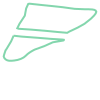

In [5]:
bound_path = np.array(get_bounds_from_string(field_bounds_str)[0])[:,:2]
bound_path2 = np.array(get_bounds_from_string(field_bounds_str)[1])[:,:2]
LineString(bound_path).union(LineString(bound_path2))

In [6]:
field_bounds_str

'[[[[24.547178806,50.039277761,-111111.0],[24.547275349,50.0393346,-111111.0],[24.547468435,50.039424164,-111111.0],[24.547814381,50.039589512,-111111.0],[24.548240779,50.039828922,-111111.0],[24.548511636,50.040042495,-111111.0],[24.548656451,50.040159615,-111111.0],[24.548849537,50.040352519,-111111.0],[24.548951443,50.04048514,-111111.0],[24.54899167,50.040593647,-111111.0],[24.548948762,50.040674597,-111111.0],[24.5488549,50.040719378,-111111.0],[24.548742267,50.040741768,-111111.0],[24.548484819,50.040755547,-111111.0],[24.54831,50.040753,-111111.0],[24.547607,50.040782,-111111.0],[24.546851,50.040886,-111111.0],[24.546209,50.040955,-111111.0],[24.545495,50.041028,-111111.0],[24.544735,50.04111,-111111.0],[24.544646,50.041097,-111111.0],[24.544512,50.040807,-111111.0],[24.544427,50.040347,-111111.0],[24.544086,50.039826,-111111.0],[24.543946,50.039543,-111111.0],[24.544045,50.039508,-111111.0],[24.544784,50.039459,-111111.0],[24.545711,50.039382,-111111.0],[24.54656,50.0393,-11111

In [7]:
len(bound_path)

31

In [46]:
# start_point = np.array([50.067829, 23.983841])[::-1]
path = np.concatenate([
    np.linspace([50.041046, 24.544801], [50.040669, 24.548822], 300),
    np.linspace([50.040497, 24.548638], [50.040834, 24.544704], 300),
    np.linspace([50.040605, 24.544640], [50.040235, 24.548363], 300),
    np.linspace([50.040019, 24.548111], [50.040353, 24.544593], 300),
    np.linspace([50.040113, 24.544453], [50.039806, 24.547839], 300),
    np.linspace([50.039593, 24.547494], [50.039902, 24.544301], 300),
    np.linspace([50.039763, 24.544219], [50.039473, 24.547330], 300)
])


diff_lat = np.random.uniform(-0.000002, 0.000002, 2100)*2
diff_lon = np.random.uniform(-0.000001, 0.000001, 2100)*2
# diff_lon = np.zeros(2100)

# path = [start_point]
# for dx, dy in zip(diff_x, diff_y):
#     path.append(path[-1] + np.array([dx, dy]))
# path = np.array(path)

# linepath = LineString(path)
# linepath.union(LineString(bound_path))
path = path + np.array([diff_lat, diff_lon]).T

# Time test for 3 consecutive 300-coordinate tracks 

In [47]:
path = path[:,::-1]

In [48]:
# parameters
# path = bound_path

track_len = 300

tool_width = 10
time = np.ones(track_len)

track_lon, track_lat = list(path[:track_len].T)

In [49]:
len(path)

2100

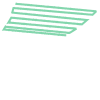

In [50]:
LineString(path+np.array([diff_lat, diff_lon]).T)

## First 300 coords

In [51]:
%%time
first_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str
)

CPU times: user 142 ms, sys: 2.58 ms, total: 145 ms
Wall time: 143 ms


## Second 300 coords

In [52]:
track_lon, track_lat = path[track_len : track_len*2].T
# track_lon, track_lat = path[track_len : ].T

In [53]:
%%time
second_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=track_lat,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=first_300['encoded_field_polygon'],
    encoded_calculated_track=first_300['encoded_calculated_track'],
    gps_geozone_num=first_300['gps_geozone_num'],
    gps_geozone_let=first_300['gps_geozone_let'],
    last_point_xy=first_300['last_point_xy'],
    last_path_distance=first_300['path_distance'][-1],
)

CPU times: user 139 ms, sys: 2.17 ms, total: 141 ms
Wall time: 140 ms


## Third 300 coords

In [54]:
track_lon, track_lat = path[track_len*2 :track_len*3].T
time = track_lon

In [55]:
%%time
third_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=second_300['encoded_field_polygon'],
    encoded_calculated_track=second_300['encoded_calculated_track'],
    gps_geozone_num=second_300['gps_geozone_num'],
    gps_geozone_let=second_300['gps_geozone_let'],
    last_point_xy=second_300['last_point_xy'],
    last_path_distance=second_300['path_distance'][-1],
)

CPU times: user 142 ms, sys: 1.76 ms, total: 144 ms
Wall time: 142 ms


## Fourth 300 coords

In [56]:
track_lon, track_lat = path[track_len*3 :track_len*4].T
time = track_lon

In [57]:
%%time
fourth_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=third_300['encoded_field_polygon'],
    encoded_calculated_track=third_300['encoded_calculated_track'],
    gps_geozone_num=third_300['gps_geozone_num'],
    gps_geozone_let=third_300['gps_geozone_let'],
    last_point_xy=third_300['last_point_xy'],
    last_path_distance=third_300['path_distance'][-1],
)

CPU times: user 145 ms, sys: 2.01 ms, total: 147 ms
Wall time: 146 ms


## Fifth 300 coords

In [58]:
track_lon, track_lat = path[track_len*4 :track_len*5].T
time = track_lon

In [59]:
%%time
fifth_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=fourth_300['encoded_field_polygon'],
    encoded_calculated_track=fourth_300['encoded_calculated_track'],
    gps_geozone_num=fourth_300['gps_geozone_num'],
    gps_geozone_let=fourth_300['gps_geozone_let'],
    last_point_xy=fourth_300['last_point_xy'],
    last_path_distance=fourth_300['path_distance'][-1],
)

CPU times: user 156 ms, sys: 1.66 ms, total: 158 ms
Wall time: 157 ms


## Sixth 300 coords

In [60]:
track_lon, track_lat = path[track_len*5 :track_len*6].T
time = track_lon

In [61]:
%%time
sixth_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=fifth_300['encoded_field_polygon'],
    encoded_calculated_track=fifth_300['encoded_calculated_track'],
    gps_geozone_num=fifth_300['gps_geozone_num'],
    gps_geozone_let=fifth_300['gps_geozone_let'],
    last_point_xy=fifth_300['last_point_xy'],
    last_path_distance=fifth_300['path_distance'][-1],
)

CPU times: user 153 ms, sys: 2.25 ms, total: 155 ms
Wall time: 154 ms


## Seventh 300 coords

In [62]:
track_lon, track_lat = path[track_len*6 :].T
time = track_lon

In [63]:
%%time
seventh_300 = get_area_and_distance(
    tool_width=tool_width,
    gps_m_deviation=1,
    
    time=time,
    track_lat=track_lat,
    track_lon=track_lon,
    
    field_bounds_str=field_bounds_str,
    encoded_field_polygon=sixth_300['encoded_field_polygon'],
    encoded_calculated_track=sixth_300['encoded_calculated_track'],
    gps_geozone_num=sixth_300['gps_geozone_num'],
    gps_geozone_let=sixth_300['gps_geozone_let'],
    last_point_xy=sixth_300['last_point_xy'],
    last_path_distance=sixth_300['path_distance'][-1],
)

CPU times: user 224 ms, sys: 2.82 ms, total: 227 ms
Wall time: 224 ms


### Calculated track area comparison

In [64]:
%%time
first_track = wkt.loads(first_300['encoded_calculated_track'])

CPU times: user 147 µs, sys: 11 µs, total: 158 µs
Wall time: 152 µs


In [65]:
%%time
second_track = wkt.loads(second_300['encoded_calculated_track'])

CPU times: user 303 µs, sys: 50 µs, total: 353 µs
Wall time: 338 µs


In [66]:
%%time
third_track = wkt.loads(third_300['encoded_calculated_track'])

CPU times: user 628 µs, sys: 64 µs, total: 692 µs
Wall time: 683 µs


In [67]:
%%time
fourth_track = wkt.loads(fourth_300['encoded_calculated_track'])

CPU times: user 1.54 ms, sys: 355 µs, total: 1.89 ms
Wall time: 1.67 ms


In [68]:
%%time
fifth_track = wkt.loads(fifth_300['encoded_calculated_track'])

CPU times: user 1.2 ms, sys: 169 µs, total: 1.37 ms
Wall time: 1.33 ms


In [69]:
%%time
sixth_track = wkt.loads(sixth_300['encoded_calculated_track'])

CPU times: user 1.02 ms, sys: 55 µs, total: 1.08 ms
Wall time: 1.06 ms


In [70]:
%%time
seventh_track = wkt.loads(seventh_300['encoded_calculated_track'])

CPU times: user 653 µs, sys: 51 µs, total: 704 µs
Wall time: 688 µs


In [71]:
%%time
field_poly = wkt.loads(first_300['encoded_field_polygon'])

CPU times: user 380 µs, sys: 29 µs, total: 409 µs
Wall time: 392 µs


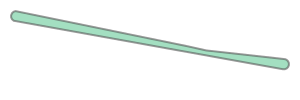

In [72]:
first_track

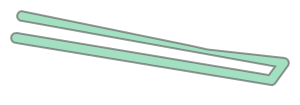

In [73]:
second_track

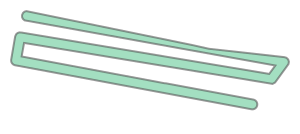

In [74]:
third_track

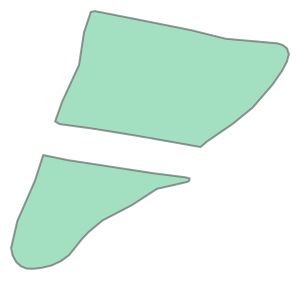

In [75]:
field_poly

In [76]:
first_track.area, field_poly.intersection(first_track).area, first_300['path_distance'][-1]

(2426.4049409019735, 2422.624222572333, 290.2905843687188)

In [77]:
second_track.area, field_poly.intersection(second_track).area

(5692.423386555412, 5688.642668224334)

In [78]:
third_track.area, field_poly.intersection(third_track).area

(8910.11856510977, 8906.33784677869)

In [79]:
fourth_track.area, field_poly.intersection(fourth_track).area

(12004.737614452111, 12000.956896121028)

In [80]:
fifth_track.area, field_poly.intersection(fifth_track).area

(14990.716120701525, 14986.93540237045)

In [81]:
sixth_track.area, field_poly.intersection(sixth_track).area

(17878.981840763452, 17875.20112243236)

In [82]:
seventh_track.area, field_poly.intersection(seventh_track).area

(20512.710922496495, 20508.930204165412)

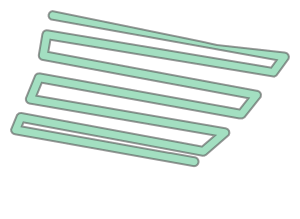

In [83]:
seventh_track